In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point

# The place where you want to retrieve the data
# OSMnx uses Nominatim/OverPass API to retrieve the data
# You can check that your place name is valid from: https://nominatim.openstreetmap.org/
place = "Kamppi, Helsinki, Finland"

# Retrieve pedestrian data
kamppi = ox.gdf_from_place(place)
G = ox.graph_from_place(place, network_type='walk')

# What did we retrieve?
G

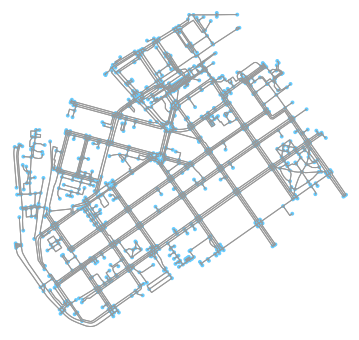

In [2]:
fig, ax = ox.plot_graph(G)

In [3]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)  # you can flag whether you want to e.g. exclude nodes

In [4]:
# Check the first rows of the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
3216400385,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755)
1372233731,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229)
1005744134,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162)
319885318,60.165062,24.925501,319885318,NaN,NaN,POINT (24.92550 60.16506)
3216400394,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766)


In [5]:
# First rows of the edges
edges.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,service,tunnel,access,bridge,junction,ref
0,3216400385,301360890,0,15240373,Kansakoulukuja,residential,30,False,13.177,"LINESTRING (24.93400 60.16755, 24.93393 60.167...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1372233731,298367080,0,86533507,NaN,footway,NaN,False,6.925,"LINESTRING (24.92927 60.16229, 24.92917 60.16225)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1372233731,292859610,0,15103120,NaN,primary_link,30,False,33.874,"LINESTRING (24.92927 60.16229, 24.92930 60.162...",2,NaN,NaN,NaN,NaN,NaN,NaN
3,1372233731,2390968896,0,"[86533504, 23025219]",Hietalahdenkatu,primary,30,False,68.200,"LINESTRING (24.92927 60.16229, 24.92868 60.162...","[2, 3]",NaN,NaN,NaN,NaN,NaN,NaN
4,1372233731,4430643601,0,"[154412960, 86533507]",NaN,footway,NaN,False,12.489,"LINESTRING (24.92927 60.16229, 24.92941 60.162...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Calculate the time (in seconds) it takes to walk through road segments
walk_speed = 4.5  # kmph
edges['walk_t'] = (( edges['length'] / (walk_speed*1000) ) * 60 * 60).round(1)

# Do the same for cycling
cycling_speed = 19  # kmph
edges['bike_t'] = (( edges['length'] / (cycling_speed*1000) ) * 60 * 60).round(1)

# Let's check what we got
edges[['length', 'walk_t', 'bike_t']].head()

,length,walk_t,bike_t
0,13.177,10.5,2.5
1,6.925,5.5,1.3
2,33.874,27.1,6.4
3,68.200,54.6,12.9
4,12.489,10.0,2.4


In [7]:
G = ox.gdfs_to_graph(gdf_nodes=nodes, gdf_edges=edges)
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [8]:
# Check only the first row from edges
for fr, to, edge in G.edges(data=True):
    print(edge)
    break

{'osmid': 15240373, 'name': 'Kansakoulukuja', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'length': 13.177, 'geometry': <shapely.geometry.linestring.LineString object at 0x7fc5211e96d0>, 'walk_t': 10.5, 'bike_t': 2.5}


In [9]:
# OSM data is in WGS84 so typically we need to use lat/lon coordinates when searching for the closest node

# Origin
orig_address = "Kalevankatu 16, Helsinki"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Ruoholahdenkatu 24, Helsinki"
dest_y, dest_x = ox.geocode(dest_address)

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: 24.936245 60.1665678
Destination coords: 24.9246625 60.1641351


In [10]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.get_nearest_node(G, point=(orig_y, orig_x), method='haversine', return_dist=True)
dest_node_id, dist_to_dest = ox.get_nearest_node(G, point=(dest_y, dest_x), method='haversine', return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 298372995 and distance: 43.872491349361404 meters.
Destination node-id: 5809140035 and distance: 48.867235001413256 meters.


In [11]:
import networkx as nx
# Calculate the paths by walking and cycling
walk_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

# Get also the actual travel times (summarize)
walk_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

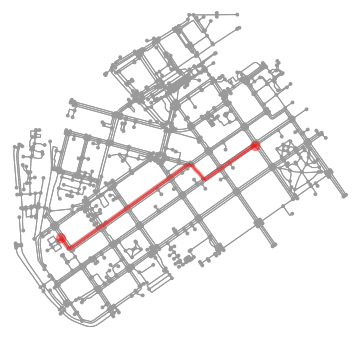

Text(0.5, 0, 'Walk time  12.0 minutes.')

In [12]:
# Walking
fig, ax = ox.plot_graph_route(G, walk_path)

# Add the travel time as title
ax.set_xlabel("Walk time {t: .1f} minutes.".format(t=walk_t/60))

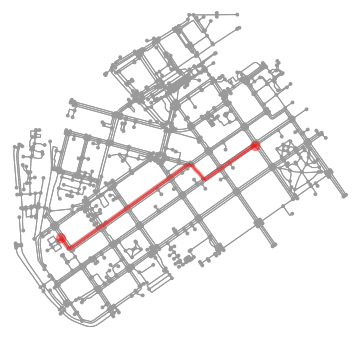

Text(0.5, 0, 'Cycling time  2.8 minutes.')

In [13]:
# Cycling
fig, ax = ox.plot_graph_route(G, bike_path)

# Add the travel time as title
ax.set_xlabel("Cycling time {t: .1f} minutes.".format(t=bike_t/60))

In [14]:
ox.plot_route_folium(G, walk_path, popup_attribute='walk_t')

In [15]:
# Calculate walk travel times originating from one location
walk_times = nx.single_source_dijkstra_path_length(G, source=orig_node_id, weight='walk_t')

In [16]:
import pandas as pd
# Convert to DataFrame and add column names
walk_times_df = pd.DataFrame([list(walk_times.keys()), list(walk_times.values())]).T
walk_times_df.columns = ['node_id', 'walk_t']

# What do we have now?
walk_times_df.head()

,node_id,walk_t
0,2.983730e+08,0.0
1,3.100429e+08,4.3
2,2.983730e+08,4.8
3,1.377212e+09,9.1
4,2.983730e+08,10.1


In [17]:
# Check the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
3216400385,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755)
1372233731,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229)
1005744134,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162)
319885318,60.165062,24.925501,319885318,NaN,NaN,POINT (24.92550 60.16506)
3216400394,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766)


In [18]:
# Merge the datasets
nodes = nodes.merge(walk_times_df, left_on='osmid', right_on='node_id')

# Check
nodes.head()

,y,x,osmid,highway,ref,geometry,node_id,walk_t
0,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755),3.216400e+09,208.4
1,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229),1.372234e+09,639.3
2,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162),1.005744e+09,775.7
3,60.165062,24.925501,319885318,NaN,NaN,POINT (24.92550 60.16506),3.198853e+08,617.4
4,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766),3.216400e+09,193.6


/home/hentenka/miniconda3/envs/python-gis/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(60.16, 60.17)

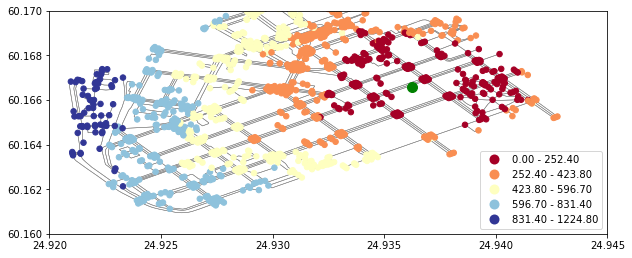

In [19]:
%matplotlib inline

# Make a GeoDataFrame for the origin point so that we can visualize it
orig = gpd.GeoDataFrame({'geometry': [Point(orig_x, orig_y)]}, index=[0], crs={'init': 'epsg:4326'})

# Plot the results with edges and the origin point (green)
ax = edges.plot(lw=0.5, color='gray', zorder=0, figsize=(10,10))
ax = nodes.plot('walk_t', ax=ax, cmap='RdYlBu', scheme='natural_breaks', k=5, markersize=30, legend=True)
ax = orig.plot(ax=ax, markersize=100, color='green')

# Adjust axis
ax.set_xlim([24.92, 24.945])
ax.set_ylim([60.160, 60.170])

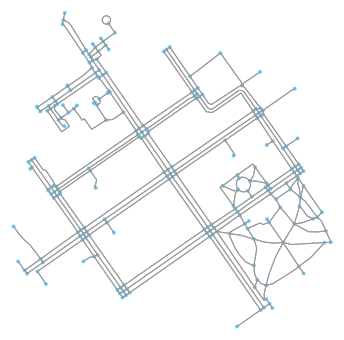

In [20]:
# Take a subgraph until 4 minutes by walking (240 seconds)
subgraph = nx.ego_graph(G, n=orig_node_id, radius=240, distance='walk_t')
fig, ax = ox.plot_graph(subgraph)